In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

%config InlineBackend.figure_format = 'retina'
from datetime import datetime

# Data Reading

## Turin Real Data
Real Turin Data is extracted from: [https://covid19.infn.it/iss/](https://covid19.infn.it/iss/)


In [2]:
turin_real_deaths = pd.read_csv('../data/turin-real/iss_bydate_torino_deceduti.csv', delimiter=',')
turin_real_positives = pd.read_csv('../data/turin-real/iss_bydate_torino_positivi.csv', delimiter=',')
turin_real_recoveries = pd.read_csv('../data/turin-real/iss_bydate_torino_ricoveri.csv', delimiter=',')
turin_real_icu = pd.read_csv('../data/turin-real/iss_bydate_torino_terapia_intensiva.csv', delimiter=',')
turin_real_symptomatic_age_wide = pd.read_csv('../data/turin-real/iss_age_date_piemonte_sintomatici.csv', delimiter=',')
turin_real_positives_age_wide = pd.read_csv('../data/turin-real/iss_age_date_piemonte_positivi.csv', delimiter=',')
turin_real_deaths_age_wide = pd.read_csv('../data/turin-real/iss_age_date_piemonte_deceduti.csv', delimiter=',')

In [3]:
turin_real_deaths_age_wide

,data,0-5 anni,6-12 anni,13-19 anni,20-29 anni,30-39 anni,40-49 anni,50-59 anni,60-69 anni,70-79 anni,80-89 anni,≥90 anni
0,2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.285714,0.0
4,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.142857,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1199,2023-06-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1200,2023-06-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.0
1201,2023-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202,2023-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def join_based_on_min_date(df1, df2):
    min_date = min(df1['date'].min(), df2['date'].min())
    if min_date == df1['date'].min():
        left_df = df1
        right_df = df2
    else:
        left_df = df2
        right_df = df1

    merged = pd.merge(left_df, right_df, on='date', how='left')
    return merged.filter(regex=r'^(?!.*casi).*$', axis=1)

def process_age_separation(df, variableName):
    result = pd.DataFrame(columns=['date', variableName+'-Student', variableName+'-Worker', variableName+'-Retired'])
    result['date'] = df['data']
    result[variableName+'-Student'] = df['0-5 anni'] + df['6-12 anni'] + df['13-19 anni'] + df['20-29 anni']
    result[variableName+'-Worker'] = df['30-39 anni'] + df['40-49 anni'] + df['50-59 anni']
    result[variableName+'-Retired'] = df['60-69 anni'] + df['70-79 anni'] + df['80-89 anni'] + df['≥90 anni']

    return result



turin_real_deaths.columns = ['date','casi','deaths_7_days']
turin_real_positives.columns = ['date','casi','positives_7_days']
turin_real_recoveries.columns = ['date','casi','recoveries_7_days']
turin_real_icu.columns = ['date','casi','icu_7_days']

turin_real_symptomatic_age = process_age_separation(turin_real_symptomatic_age_wide,'symptomatic')
turin_real_positives_age = process_age_separation(turin_real_positives_age_wide,'positives')
turin_real_deaths_age = process_age_separation(turin_real_deaths_age_wide,'deaths')

turin_real = join_based_on_min_date(turin_real_deaths,turin_real_positives)
turin_real = join_based_on_min_date(turin_real,turin_real_recoveries)
turin_real = join_based_on_min_date(turin_real,turin_real_icu)
turin_real = join_based_on_min_date(turin_real,turin_real_symptomatic_age)
turin_real = join_based_on_min_date(turin_real,turin_real_positives_age)
turin_real = join_based_on_min_date(turin_real,turin_real_deaths_age)
turin_real



,date,symptomatic-Student,symptomatic-Worker,symptomatic-Retired,positives_7_days,deaths_7_days,recoveries_7_days,icu_7_days,positives-Student,positives-Worker,positives-Retired,deaths-Student,deaths-Worker,deaths-Retired
0,2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-31,0.142857,1.714286,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-01,0.142857,1.571429,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,2023-05-01,0.285714,0.714286,1.571429,100.285714,0.285714,3.714286,NaN,17.571429,63.285714,89.000000,0.0,0.0,0.285714
1190,2023-05-02,0.142857,0.571429,1.142857,97.000000,0.142857,3.285714,NaN,16.142857,60.000000,88.428571,0.0,0.0,0.142857
1191,2023-05-03,NaN,NaN,NaN,93.000000,0.285714,3.428571,NaN,16.285714,58.000000,84.714286,0.0,0.0,0.285714
1192,2023-05-04,NaN,NaN,NaN,90.285714,0.285714,3.428571,NaN,15.285714,58.142857,82.714286,0.0,0.0,0.428571


### Data Adjustment For Population

Dati estratti da: [http://dati.istat.it/Index.aspx?QueryId=18540](http://dati.istat.it/Index.aspx?QueryId=18540)


In [5]:
## Adjust data based on Turin Polulation
population_df = pd.DataFrame(columns=['Year','Region','Province','City'])

population_df.loc[len(population_df)] = [2020, 4311217,2230946,857910]
population_df.loc[len(population_df)] = [2021, 4274945,2219206,858205]
population_df.loc[len(population_df)] = [2022, 4256350,2208370,848748]
population_df.loc[len(population_df)] = [2023, 4240736,2198237,841600]

population_df

,Year,Region,Province,City
0,2020,4311217,2230946,857910
1,2021,4274945,2219206,858205
2,2022,4256350,2208370,848748
3,2023,4240736,2198237,841600


In [6]:
turin_real_data_origin = {
    'deaths_7_days':'province',
    'positives_7_days':'province',
    'recoveries_7_days':'province',
    'icu_7_days':'province',
    'symptomatic-Student':'region',
    'symptomatic-Worker':'region',
    'symptomatic-Retired':'region',
    'positives-Student':'region',
    'positives-Worker':'region',
    'positives-Retired':'region',
    'deaths-Student':'region',
    'deaths-Worker':'region',
    'deaths-Retired':'region'
}

turin_real_data_origin

{'deaths_7_days': 'province',
 'positives_7_days': 'province',
 'recoveries_7_days': 'province',
 'icu_7_days': 'province',
 'symptomatic-Student': 'region',
 'symptomatic-Worker': 'region',
 'symptomatic-Retired': 'region',
 'positives-Student': 'region',
 'positives-Worker': 'region',
 'positives-Retired': 'region',
 'deaths-Student': 'region',
 'deaths-Worker': 'region',
 'deaths-Retired': 'region'}

In [7]:
def get_multiplier(variable_name, year):
    year_data = population_df[population_df['Year'] == year]
    data_from = turin_real_data_origin[variable_name]
    multiplier = 1
    if data_from == 'region':
        multiplier = year_data['City'] / year_data['Region']

    if data_from == 'province':
        multiplier = year_data['City'] / year_data['Province']

    if data_from == 'city':
        multiplier = 1

    return multiplier

def adjust_value_for_year_population(row):
    year = int(row['date'][:4])  # Extract the year from the 'date' column as an integer

    result_dictionary = {}
    for column_name, value in row.items():
        if column_name == 'date':
            result_dictionary[column_name] = value
            continue
        multiplier = get_multiplier(column_name, year)
        result_dictionary[column_name] = row[column_name] * multiplier
        #row[column_name] *= multiplier

    return pd.Series(result_dictionary)



turin_real_adjusted = turin_real.copy()
turin_real_adjusted = turin_real_adjusted.apply(adjust_value_for_year_population ,axis=1)

for columnName in turin_real_adjusted.columns:
    if columnName == 'date':
        continue
    turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])

turin_real_adjusted


C:\Users\Utente\AppData\Local\Temp\ipykernel_16772\958216839.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])
C:\Users\Utente\AppData\Local\Temp\ipykernel_16772\958216839.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])
C:\Users\Utente\AppData\Local\Temp\ipykernel_16772\958216839.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  turin_real_adjusted[columnName] = turin_real_adjusted[columnName].astype(turin_real.dtypes[columnName])
C:\Users\Utente\AppData\Local\Temp\ipykernel_1677

,date,symptomatic-Student,symptomatic-Worker,symptomatic-Retired,positives_7_days,deaths_7_days,recoveries_7_days,icu_7_days,positives-Student,positives-Worker,positives-Retired,deaths-Student,deaths-Worker,deaths-Retired
0,2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-31,0.028428,0.341134,0.056856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-01,0.028428,0.312706,0.056856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,2023-05-01,0.056702,0.141754,0.311860,38.394612,0.109386,1.422023,NaN,3.487157,12.559437,17.662594,0.0,0.0,0.056702
1190,2023-05-02,0.028351,0.113403,0.226807,37.136669,0.054693,1.257943,NaN,3.203649,11.907367,17.549191,0.0,0.0,0.028351
1191,2023-05-03,NaN,NaN,NaN,35.605260,0.109386,1.312636,NaN,3.232000,11.510455,16.812068,0.0,0.0,0.056702
1192,2023-05-04,NaN,NaN,NaN,34.566090,0.109386,1.312636,NaN,3.033544,11.538806,16.415156,0.0,0.0,0.085053


### Check Data

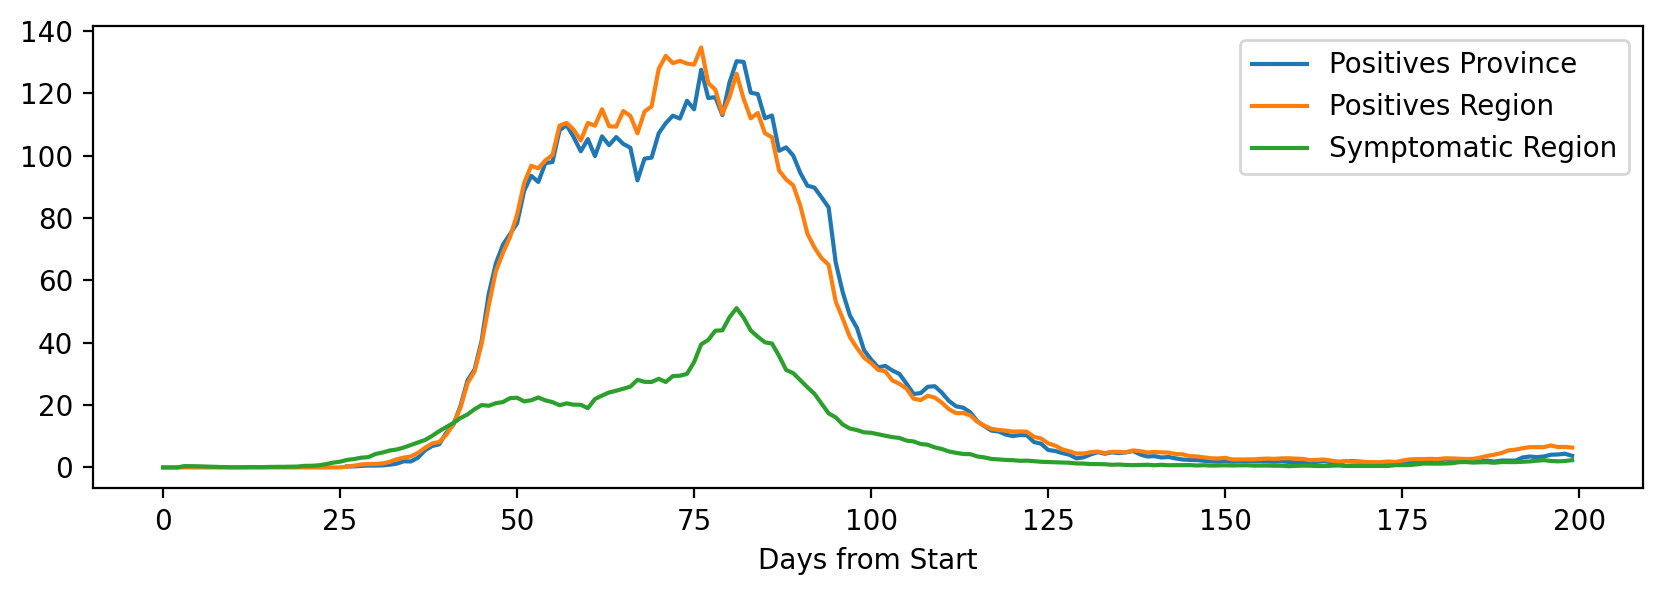

In [8]:
days = 200
fig,axes = plt.subplots(figsize=(10, 3))

axes.plot(turin_real_adjusted.loc[:days-1,'positives_7_days'], label='Positives Province')

by_age_positives = turin_real_adjusted[['positives-Student','positives-Worker','positives-Retired']].iloc[:days].sum(axis=1)
axes.plot(by_age_positives, label='Positives Region')

by_age_symptomatic = turin_real_adjusted[['symptomatic-Student','symptomatic-Worker','symptomatic-Retired']].iloc[:days].sum(axis=1)
axes.plot(by_age_symptomatic, label='Symptomatic Region')

# Add plot labels and legend
plt.xlabel('Days from Start')
plt.legend()


#plt.tight_layout()
# Show the plot
plt.show()

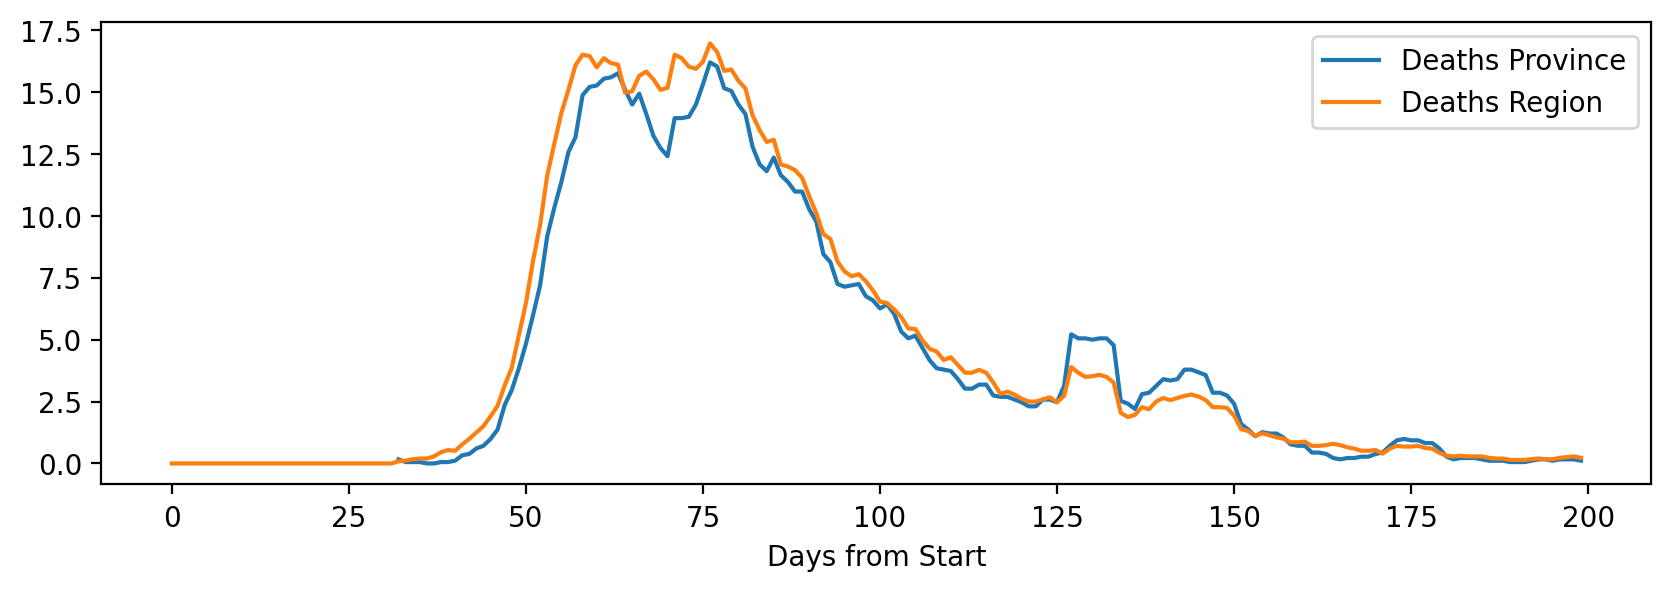

In [9]:
days = 200
fig,axes = plt.subplots(figsize=(10, 3))

axes.plot(turin_real_adjusted.loc[:days-1,'deaths_7_days'], label='Deaths Province')

by_age_positives = turin_real_adjusted[['deaths-Student','deaths-Worker','deaths-Retired']].iloc[:days].sum(axis=1)
axes.plot(by_age_positives, label='Deaths Region')

# Add plot labels and legend
plt.xlabel('Days from Start')
plt.legend()


#plt.tight_layout()
# Show the plot
plt.show()

In [10]:
turin_real_adjusted

,date,symptomatic-Student,symptomatic-Worker,symptomatic-Retired,positives_7_days,deaths_7_days,recoveries_7_days,icu_7_days,positives-Student,positives-Worker,positives-Retired,deaths-Student,deaths-Worker,deaths-Retired
0,2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-31,0.028428,0.341134,0.056856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-01,0.028428,0.312706,0.056856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,2023-05-01,0.056702,0.141754,0.311860,38.394612,0.109386,1.422023,NaN,3.487157,12.559437,17.662594,0.0,0.0,0.056702
1190,2023-05-02,0.028351,0.113403,0.226807,37.136669,0.054693,1.257943,NaN,3.203649,11.907367,17.549191,0.0,0.0,0.028351
1191,2023-05-03,NaN,NaN,NaN,35.605260,0.109386,1.312636,NaN,3.232000,11.510455,16.812068,0.0,0.0,0.056702
1192,2023-05-04,NaN,NaN,NaN,34.566090,0.109386,1.312636,NaN,3.033544,11.538806,16.415156,0.0,0.0,0.085053


## Simulations
For simulations we read all the simulation files in a specific folder and store them in a dictionary with their simulation ID

In [11]:
simulations_logs_dir = '../data/simulations'
simulations_logs_df_dictionary = {}
simulations_conf_df_dictionary = {}

for sim_folder_name in os.listdir(simulations_logs_dir):
    # Regular expression to find the first two-digit number
    pattern = r'(\d{2})'
    sim_number = int(re.search(pattern, sim_folder_name).group())

    print(sim_number)
    log_file_path = os.path.join(simulations_logs_dir,sim_folder_name, 'log_'+sim_folder_name +'.csv')
    log_df = pd.read_csv(log_file_path, delimiter=';')
    simulations_logs_df_dictionary[sim_number] = log_df

    conf_file_path = os.path.join(simulations_logs_dir,sim_folder_name, 'conf_'+sim_folder_name + '.json')
    #conf_df = pd.read_json(log_file_path)
    #simulations_conf_df_dictionary[sim_number] = conf_df

1
20
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
79
80


In [12]:
simulations_logs_df_dictionary[max(simulations_logs_df_dictionary.keys())].columns

Index(['Days', 'Hours', 'Minutes', 'Students', 'Workers', 'OccupiedWorkers',
       'EssentialJobWorkers', 'Retired', 'ExposedStudentsByDay',
       'ExposedWorkersByDay', 'ExposedRetiredByDay', 'ExposedVaccinatedByDay',
       'ExposedAtHome', 'ExposedAtWork', 'ExposedAtSchool',
       'ExposedAtRetireHome', 'ExposedAtFriendsHome', 'ExposedAtPark',
       'ExposedAtPub', 'ExposedOnRoad', 'ExposedAtSupermarket',
       'ExposedAtHospital', 'ExposedAtGym', 'SymptomaticStudentsByDay',
       'SymptomaticWorkersByDay', 'SymptomaticRetiredByDay',
       'AsymptomaticStudentsByDay', 'AsymptomaticWorkersByDay',
       'AsymptomaticRetiredByDay', 'CriticalStudentsByDay',
       'CriticalWorkersByDay', 'CriticalRetiredByDay',
       'IntensiveStudentsByDay', 'IntensiveWorkersByDay',
       'IntensiveRetiredByDay', 'DeathsCriticalStudentsByDay',
       'DeathsCriticalWorkersByDay', 'DeathsCriticalRetiredByDay',
       'DeathsIntensiveStudentsByDay', 'DeathsIntensiveWorkersByDay',
       'Deaths

In [13]:
simulations_logs_df_dictionary[max(simulations_logs_df_dictionary.keys())]

,Days,Hours,Minutes,Students,Workers,OccupiedWorkers,EssentialJobWorkers,Retired,ExposedStudentsByDay,ExposedWorkersByDay,...,PeopleVisitedOutdoor,CompletedDayWorkCounter,MaxTimeAtWork,MinTimeAtWork,TotalTimeAtWork,EntitiesWorked,EntitiesNotStartedWork,EntitiesNotCompletedWork,NonWorkersBeenToWork,Unnamed: 61
0,0,0,0,190324,368930,177221,81669,298656,0,0,...,0,0,0,9999999999,0,0,258890,0,0,NaN
1,1,0,0,190324,368930,177221,81669,298656,0,1,...,89375,0,624,10041623609,0,133744,10499,114187,0,NaN
2,2,0,0,190324,368930,177221,81669,298656,3,15,...,63620,0,2280,10062713789,0,197613,9929,50972,0,NaN
3,3,0,0,190324,368930,177221,81669,298656,1,16,...,169,0,3296,10067876013,0,215366,9929,33257,0,NaN
4,4,0,0,190324,368930,177221,81669,298656,4,15,...,9,0,5082,10069085229,0,219835,9929,28819,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,888,0,0,190324,368924,177221,81669,298404,4,7,...,0,0,1282484,10075737875,0,204259,9928,44526,0,NaN
889,889,0,0,190324,368924,177221,81669,298404,3,3,...,0,0,1280892,10075743955,0,204306,9928,44479,0,NaN
890,890,0,0,190324,368924,177221,81669,298404,10,12,...,0,0,1285338,10075827005,0,204443,9928,44342,0,NaN
891,891,0,0,190324,368924,177221,81669,298404,2,7,...,0,0,1285278,10075848675,0,204485,9928,44300,0,NaN


### Data Consistency Check

In [14]:
def check_simulation_log_consistency(simulation_log):

    message = ""
    data_inconsistent_message = "Data is inconsistent for the following metrics:"
    #check death counts
    categories_death_sum = simulation_log['TotDeathStudent'] + simulation_log['TotDeathWorker'] + simulation_log['TotDeathRetired']
    death_series_consistent = (categories_death_sum == simulation_log['Death']).all()

    if not death_series_consistent:  data_inconsistent_message += "Deaths // "

    #check positives counts
    positives_sum = simulation_log['SymptomaticNew'] + simulation_log['AsymptomaticNew']
    infected_sum = simulation_log['InfectedStudentNew'] + simulation_log['InfectedWorkerNew'] + simulation_log['InfectedRetiredNew']
    positives_series_consistent = (positives_sum == infected_sum).all()

    if not positives_series_consistent: data_inconsistent_message += "Positives // "

    #check infections counts -> the sum of infections between age groups should match that of the infection locations

    location_infections_columns = ['InfectionsAtHome','InfectionsAtWork','InfectionsAtSchool','InfectionsAtOAHome','InfectionsAtOutdoor','InfectionsAtIndoor']
    location_infections_series_consistent = True
    if all(column in simulation_log.columns for column in location_infections_columns):
        location_infections_sum = simulation_log[location_infections_columns].sum(axis = 1)
        location_infections_series_consistent = (infected_sum == location_infections_sum).all()
    else:
        location_infections_series_consistent = True

    if not location_infections_series_consistent: data_inconsistent_message += "Infections Count vs Location // "

    #REPORT
    is_data_consistent = death_series_consistent and positives_series_consistent and location_infections_series_consistent

    if is_data_consistent:
        return "Data is consistent"
    else:
        return data_inconsistent_message

In [15]:
#TODO
#for simulations_log_key in simulations_logs_df_dictionary.keys():
#    print("Simulation: ", simulations_log_key, "->", check_simulation_log_consistency(simulations_logs_df_dictionary[simulations_log_key]))


# Data Loading
The following code snippets are for loading the read data into a defined scheme (with matching names) for both the real and the similations

The overall structure should be the following:

- Date
- DeathsByDay TotalDeaths
- PositivesByDay TotalPositives

In [16]:
shared_column_names = ['Date',
                       'DeathsStudentByDay','DeathsWorkerByDay','DeathsRetiredByDay','DeathsByDay',
                       'DeathsStudentTotal','DeathsWorkerTotal','DeathsRetiredTotal','DeathsTotal',
                       'AsymptomaticStudentByDay','AsymptomaticWorkerByDay','AsymptomaticRetiredByDay','AsymptomaticAllByDay', 'AsymptomaticTotal',
                       'SymptomaticStudentByDay','SymptomaticWorkerByDay','SymptomaticRetiredByDay','SymptomaticByDay', 'SymptomaticTotal',
                       'PositivesStudentByDay','PositivesWorkerByDay','PositivesRetiredByDay','PositivesByDay', 'PositivesTotal',
                       'DeathToPositivesRatioStudent','DeathToPositivesRatioWorker','DeathToPositivesRatioRetired','DeathToPositivesRatio']

use_moving_average = True

## Turin Real

In [17]:
turin_real_adjusted.columns

Index(['date', 'symptomatic-Student', 'symptomatic-Worker',
       'symptomatic-Retired', 'positives_7_days', 'deaths_7_days',
       'recoveries_7_days', 'icu_7_days', 'positives-Student',
       'positives-Worker', 'positives-Retired', 'deaths-Student',
       'deaths-Worker', 'deaths-Retired'],
      dtype='object')

In [18]:
turin_data = pd.DataFrame(columns=shared_column_names)

turin_data['Date'] = pd.date_range(start=turin_real_adjusted['date'][0], periods=len(turin_real))

### DEATHS BY DAY ###
turin_data['DeathsStudentByDay'] = turin_real_adjusted['deaths-Student']
turin_data['DeathsWorkerByDay'] = turin_real_adjusted['deaths-Worker']
turin_data['DeathsRetiredByDay'] = turin_real_adjusted['deaths-Retired']
turin_data['DeathsByDay'] = turin_data[['DeathsStudentByDay','DeathsWorkerByDay','DeathsRetiredByDay']].sum(axis=1)

### DEATHS TOTAL ###
turin_data['DeathsStudentTotal'] = turin_data['DeathsStudentByDay'].cumsum()
turin_data['DeathsWorkerTotal'] = turin_data['DeathsWorkerByDay'].cumsum()
turin_data['DeathsRetiredTotal'] = turin_data['DeathsRetiredByDay'].cumsum()
turin_data['DeathsTotal'] = turin_data[['DeathsStudentTotal','DeathsWorkerTotal','DeathsRetiredTotal']].sum(axis=1)

turin_data['PositivesStudentByDay'] = turin_real_adjusted['positives-Student']
turin_data['PositivesWorkerByDay'] = turin_real_adjusted['positives-Worker']
turin_data['PositivesRetiredByDay'] = turin_real_adjusted['positives-Retired']
turin_data['PositivesByDay'] = turin_data[['PositivesStudentByDay','PositivesWorkerByDay','PositivesRetiredByDay']].sum(axis=1)
turin_data['PositivesTotal'] = turin_data['PositivesByDay'].cumsum()

turin_data['SymptomaticStudentByDay'] = turin_real_adjusted['symptomatic-Student']
turin_data['SymptomaticWorkerByDay'] = turin_real_adjusted['symptomatic-Worker']
turin_data['SymptomaticRetiredByDay'] = turin_real_adjusted['symptomatic-Retired']
turin_data['SymptomaticByDay'] = turin_data[['SymptomaticStudentByDay','SymptomaticWorkerByDay','SymptomaticRetiredByDay']].sum(axis=1)
turin_data['SymptomaticTotal'] = turin_data['SymptomaticByDay'].cumsum()

turin_data['AsymptomaticStudentByDay'] = turin_data['PositivesStudentByDay'] - turin_data['SymptomaticStudentByDay']
turin_data['AsymptomaticWorkerByDay'] = turin_data['PositivesWorkerByDay'] - turin_data['SymptomaticWorkerByDay']
turin_data['AsymptomaticRetiredByDay'] = turin_data['PositivesRetiredByDay'] - turin_data['SymptomaticRetiredByDay']
turin_data['AsymptomaticByDay'] = turin_data[['AsymptomaticStudentByDay','AsymptomaticWorkerByDay','AsymptomaticRetiredByDay']].sum(axis=1)
turin_data['AsymptomaticTotal'] = turin_data['AsymptomaticByDay'].cumsum()


turin_data['DeathToPositivesRatio'] = turin_data['DeathsTotal'] / turin_data['PositivesTotal']

turin_data

,Date,DeathsStudentByDay,DeathsWorkerByDay,DeathsRetiredByDay,DeathsByDay,DeathsStudentTotal,DeathsWorkerTotal,DeathsRetiredTotal,DeathsTotal,AsymptomaticStudentByDay,...,PositivesStudentByDay,PositivesWorkerByDay,PositivesRetiredByDay,PositivesByDay,PositivesTotal,DeathToPositivesRatioStudent,DeathToPositivesRatioWorker,DeathToPositivesRatioRetired,DeathToPositivesRatio,AsymptomaticByDay
0,2020-01-28,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
1,2020-01-29,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
2,2020-01-30,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
3,2020-01-31,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
4,2020-02-01,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,2023-05-01,0.0,0.0,0.056702,0.056702,2.592098,108.566968,2793.679001,2904.838067,3.430456,...,3.487157,12.559437,17.662594,33.709189,343129.441203,NaN,NaN,NaN,0.008466,33.198873
1190,2023-05-02,0.0,0.0,0.028351,0.028351,2.592098,108.566968,2793.707352,2904.866418,3.175298,...,3.203649,11.907367,17.549191,32.660207,343162.101409,NaN,NaN,NaN,0.008465,32.291645
1191,2023-05-03,0.0,0.0,0.056702,0.056702,2.592098,108.566968,2793.764054,2904.923120,NaN,...,3.232000,11.510455,16.812068,31.554523,343193.655932,NaN,NaN,NaN,0.008464,0.000000
1192,2023-05-04,0.0,0.0,0.085053,0.085053,2.592098,108.566968,2793.849106,2905.008172,NaN,...,3.033544,11.538806,16.415156,30.987505,343224.643437,NaN,NaN,NaN,0.008464,0.000000


## Simulations

In [19]:
sim_start_date = pd.to_datetime('2020-02-20')
sim_start_date

Timestamp('2020-02-20 00:00:00')

In [20]:
def load_one_simulation(simulation_df):
    sim = pd.DataFrame(columns=shared_column_names)

    ### DEATHS BY DAY ###
    sim['DeathsStudentByDay'] = simulation_df['DeathsCriticalStudentsByDay'] + simulation_df['DeathsIntensiveStudentsByDay']
    sim['DeathsWorkerByDay'] = simulation_df['DeathsCriticalWorkersByDay'] + simulation_df['DeathsIntensiveWorkersByDay']
    sim['DeathsRetiredByDay'] = simulation_df['DeathsCriticalRetiredByDay'] + simulation_df['DeathsIntensiveRetiredByDay']
    sim['DeathsByDay'] = sim[['DeathsStudentByDay','DeathsWorkerByDay','DeathsRetiredByDay']].sum(axis=1)

    ### DEATHS TOTAL ###
    sim['DeathsStudentTotal'] = sim['DeathsStudentByDay'].cumsum()
    sim['DeathsWorkerTotal'] = sim['DeathsWorkerByDay'].cumsum()
    sim['DeathsRetiredTotal'] = sim['DeathsRetiredByDay'].cumsum()
    sim['DeathsTotal'] = sim[['DeathsStudentTotal','DeathsWorkerTotal','DeathsRetiredTotal']].sum(axis=1)

    sim['SymptomaticStudentByDay'] = simulation_df['SymptomaticStudentsByDay']
    sim['SymptomaticWorkerByDay'] = simulation_df['SymptomaticWorkersByDay']
    sim['SymptomaticRetiredByDay'] = simulation_df['SymptomaticRetiredByDay']
    sim['SymptomaticByDay'] = sim[['SymptomaticStudentByDay','SymptomaticWorkerByDay','SymptomaticRetiredByDay']].sum(axis=1)
    sim['SymptomaticTotal'] = sim['SymptomaticByDay'].cumsum()

    sim['AsymptomaticStudentByDay'] = simulation_df['AsymptomaticStudentsByDay']
    sim['AsymptomaticWorkerByDay'] = simulation_df['AsymptomaticWorkersByDay']
    sim['AsymptomaticRetiredByDay'] = simulation_df['AsymptomaticRetiredByDay']
    sim['AsymptomaticByDay'] = sim[['AsymptomaticStudentByDay','AsymptomaticWorkerByDay','AsymptomaticRetiredByDay']].sum(axis=1)
    sim['AsymptomaticTotal'] = sim['AsymptomaticByDay'].cumsum()

    sim['PositivesStudentByDay'] = sim['AsymptomaticStudentByDay'] + sim['SymptomaticStudentByDay']
    sim['PositivesWorkerByDay'] = sim['AsymptomaticWorkerByDay'] + sim['SymptomaticWorkerByDay']
    sim['PositivesRetiredByDay'] = sim['AsymptomaticRetiredByDay'] + sim['SymptomaticRetiredByDay']
    sim['PositivesByDay'] = sim['PositivesStudentByDay'] + sim['PositivesWorkerByDay'] + sim['PositivesRetiredByDay']
    sim['PositivesTotal'] = sim['PositivesByDay'].cumsum()

    sim['DeathToPositivesRatio'] = sim['DeathsTotal'] / sim['PositivesTotal']

    sim['Date'] = pd.date_range(start=sim_start_date, periods=len(simulation_df))

    return sim


first_key, first_value = next(iter(simulations_logs_df_dictionary.items()))
simulation_example = load_one_simulation(first_value)
simulation_example

,Date,DeathsStudentByDay,DeathsWorkerByDay,DeathsRetiredByDay,DeathsByDay,DeathsStudentTotal,DeathsWorkerTotal,DeathsRetiredTotal,DeathsTotal,AsymptomaticStudentByDay,...,PositivesStudentByDay,PositivesWorkerByDay,PositivesRetiredByDay,PositivesByDay,PositivesTotal,DeathToPositivesRatioStudent,DeathToPositivesRatioWorker,DeathToPositivesRatioRetired,DeathToPositivesRatio,AsymptomaticByDay
0,2020-02-20,0,0,0,0,0,0,0,0,57,...,78,148,124,350,350,NaN,NaN,NaN,0.0,250
1,2020-02-21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,350,NaN,NaN,NaN,0.0,0
2,2020-02-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,350,NaN,NaN,NaN,0.0,0
3,2020-02-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,350,NaN,NaN,NaN,0.0,0
4,2020-02-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,350,NaN,NaN,NaN,0.0,0
5,2020-02-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,350,NaN,NaN,NaN,0.0,0
6,2020-02-26,0,0,0,0,0,0,0,0,0,...,0,2,9,11,361,NaN,NaN,NaN,0.0,4
7,2020-02-27,0,0,0,0,0,0,0,0,0,...,0,4,8,12,373,NaN,NaN,NaN,0.0,5
8,2020-02-28,0,0,0,0,0,0,0,0,0,...,0,12,10,22,395,NaN,NaN,NaN,0.0,15
9,2020-02-29,0,0,0,0,0,0,0,0,1,...,1,13,19,33,428,NaN,NaN,NaN,0.0,23


In [21]:
sims_data = {}
for sim_number, sim_original_df in simulations_logs_df_dictionary.items():
    sims_data[sim_number] = load_one_simulation(sim_original_df)

# Real vs Simulation Analysis

In [70]:
#simulations_to_compare = [18,24,39,40]
#simulations_to_compare = [39,40]
#simulations_to_compare = [18,39]
#simulations_to_compare = [41,42,43,44]
#simulations_to_compare = [42,46]
#simulations_to_compare = [46,47,48]
#simulations_to_compare = [41,45]
#simulations_to_compare = [47,48,49,50]
#simulations_to_compare = [53,54,56]
#simulations_to_compare = [56,57,58]
#simulations_to_compare = [59,60]
#simulations_to_compare = [62,63,64]
#simulations_to_compare = [62,63,65,66,67]
#simulations_to_compare = [63,67]
simulations_to_compare = [63,79,80]
simulations_to_compare = [63,80]

def plot_compare_real_sims(turin_data_in, sims_data_dictionary_in, column_name, simulations_to_show, start_date, end_date):

    fig,axes = plt.subplots(figsize=(10, 2))

    mask = (turin_data_in['Date'] >= start_date) & (turin_data_in['Date'] <= end_date)
    real_series = turin_data_in.loc[mask, column_name].reset_index(drop=True)
    axes.plot(real_series, label='Real')

    real_lockdown = '2020-03-11'
    real_date_series = turin_data_in.loc[mask, 'Date'].reset_index(drop=True)
    matching_rows = real_date_series[real_date_series == pd.to_datetime(real_lockdown)].index
    if not matching_rows.empty:
        axes.axvline(matching_rows[0], color='blue', linestyle='--', label='Real Lockdown')

    for idx in simulations_to_show:
        sim_df = sims_data_dictionary_in.get(idx)

        if sim_df is not None and column_name in sim_df.columns and 'Date' in sim_df.columns:
            mask = (sim_df['Date'] >= start_date) & (sim_df['Date'] <= end_date)
            series = sim_df.loc[mask, column_name].reset_index(drop=True)
            #moving average
            #series = series.rolling(window=7).mean()
            axes.plot(series, label=idx)

    # Add plot labels and legend
    #plt.xlabel('Days from Start')
    #plt.xticks(range(26,len(real_series), 10),rotation=45)
    #plt.ylabel(column_name)
    plt.title(column_name)
    plt.legend()


    #plt.tight_layout()
    # Show the plot
    plt.show()

## Deaths

### By Day

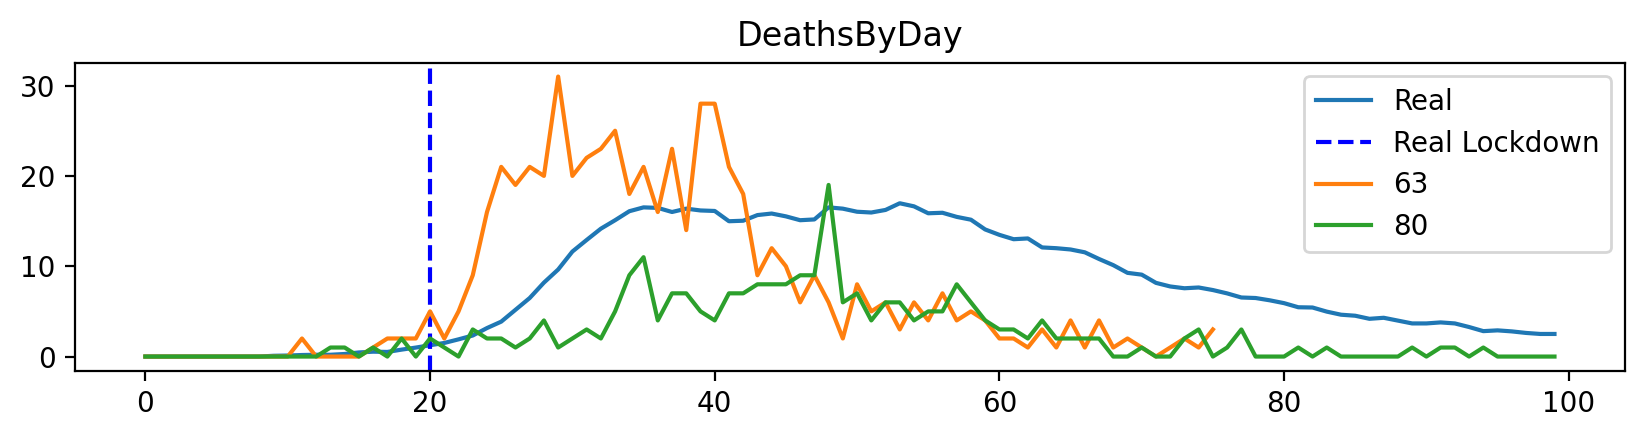

In [71]:
plotting_start_date = pd.to_datetime('2020-2-20')
plotting_end_date = pd.date_range(start=plotting_start_date, periods=100)[-1]

plot_compare_real_sims(turin_data, sims_data, 'DeathsByDay', simulations_to_compare , plotting_start_date, plotting_end_date)

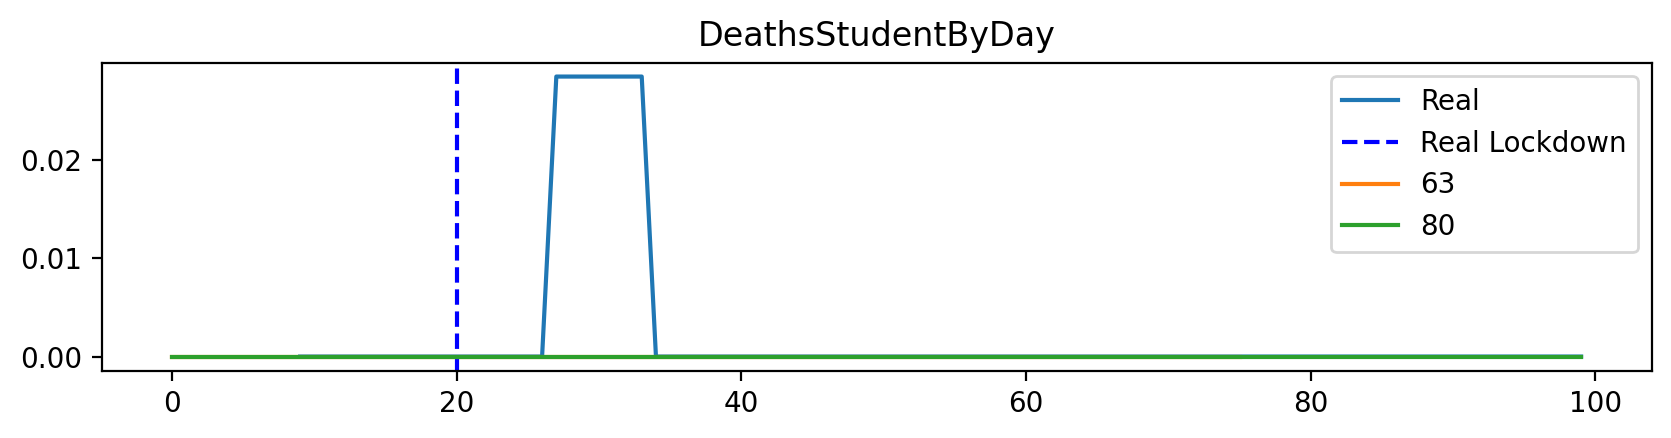

In [72]:
plot_compare_real_sims(turin_data, sims_data, 'DeathsStudentByDay', simulations_to_compare, plotting_start_date, plotting_end_date)

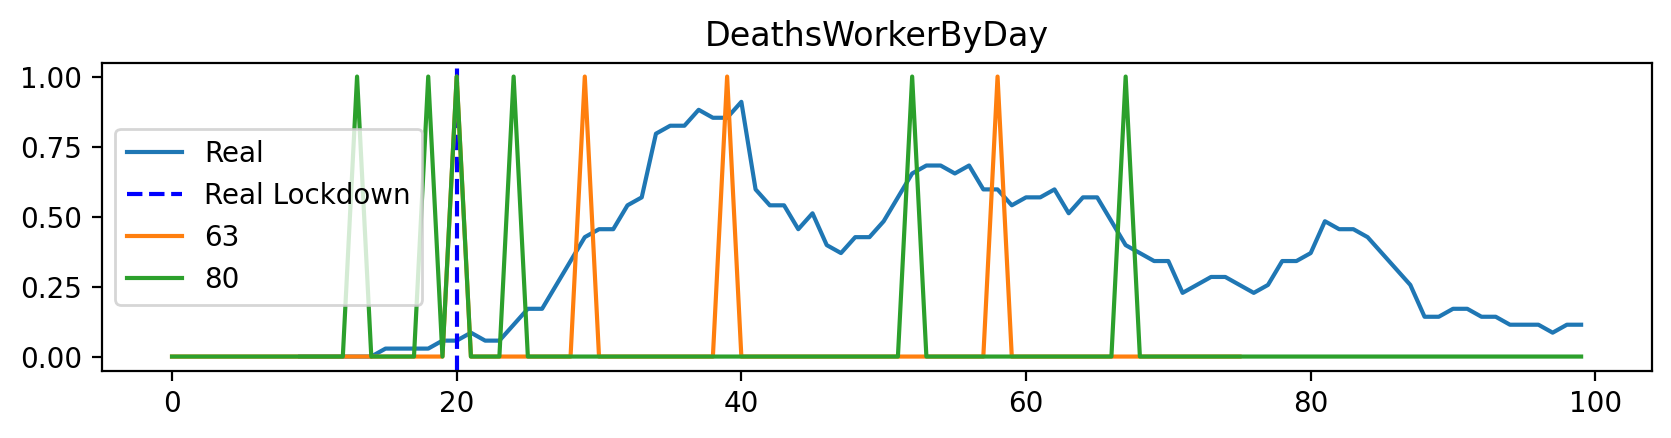

In [73]:
plot_compare_real_sims(turin_data, sims_data, 'DeathsWorkerByDay', simulations_to_compare, plotting_start_date, plotting_end_date)

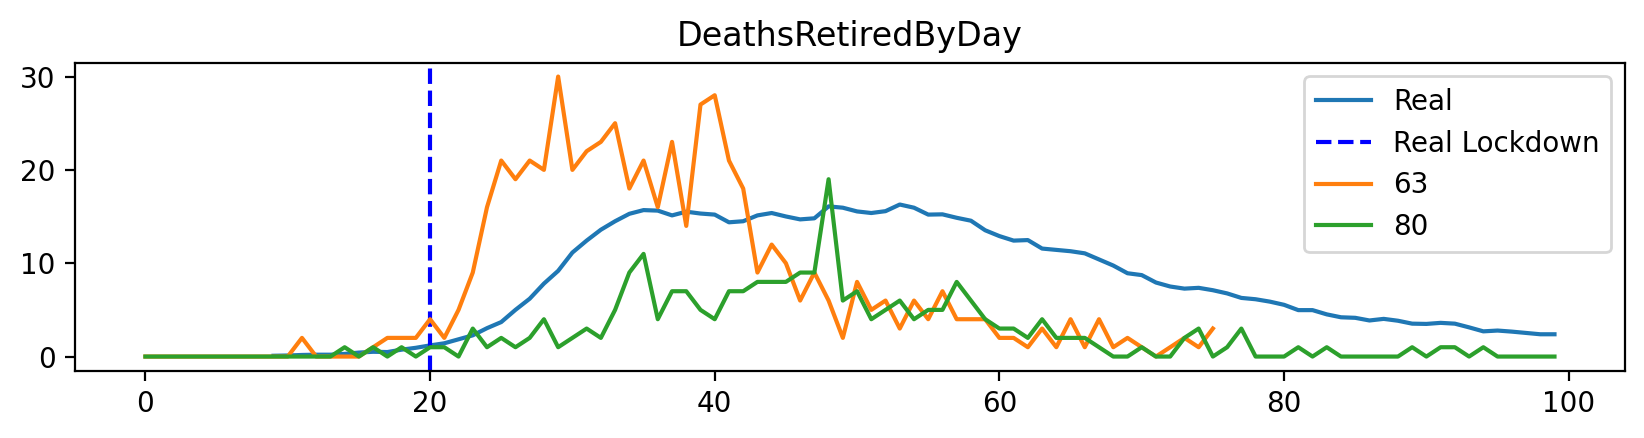

In [74]:
plot_compare_real_sims(turin_data, sims_data, 'DeathsRetiredByDay', simulations_to_compare, plotting_start_date, plotting_end_date)

### Total

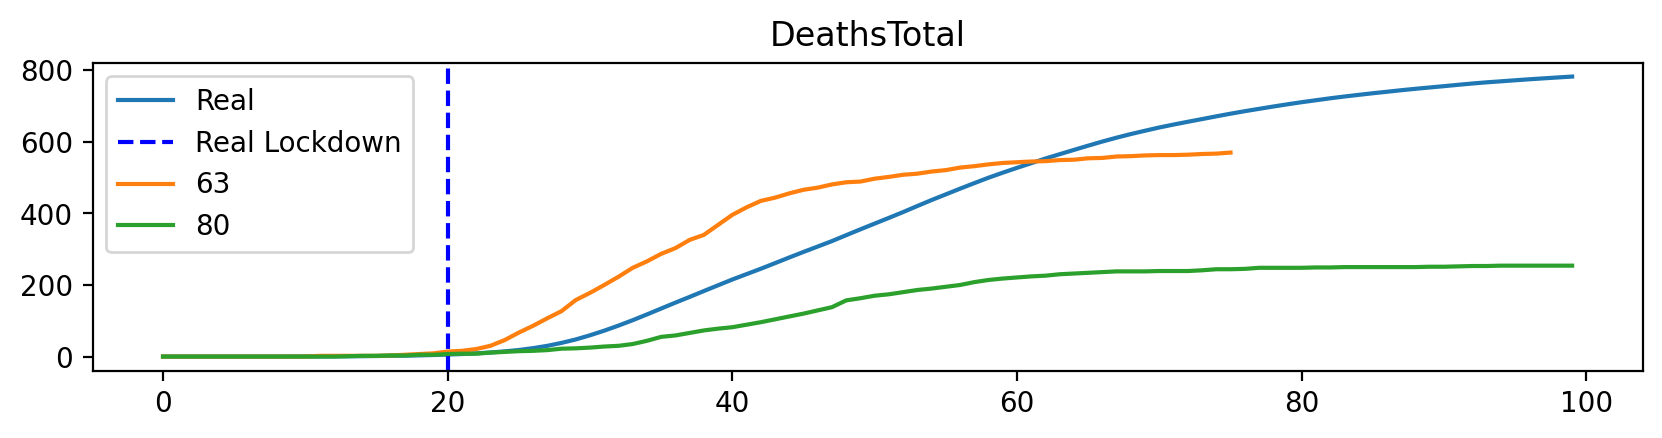

In [75]:
plot_compare_real_sims(turin_data, sims_data, 'DeathsTotal', simulations_to_compare, plotting_start_date, plotting_end_date)

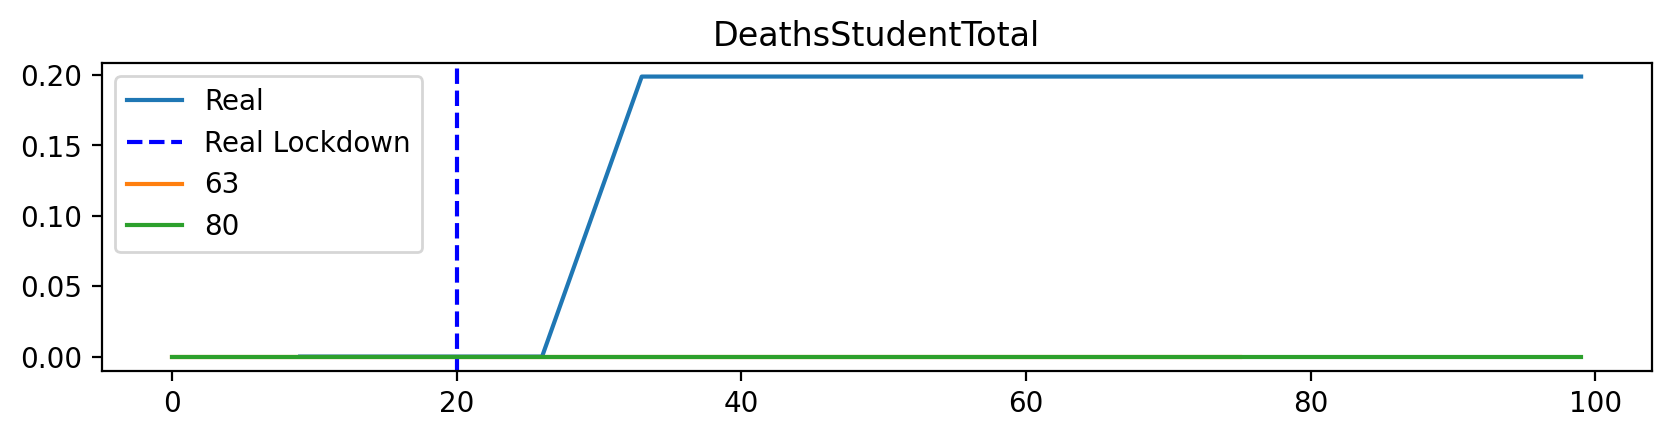

In [76]:
plot_compare_real_sims(turin_data, sims_data, 'DeathsStudentTotal', simulations_to_compare, plotting_start_date, plotting_end_date)

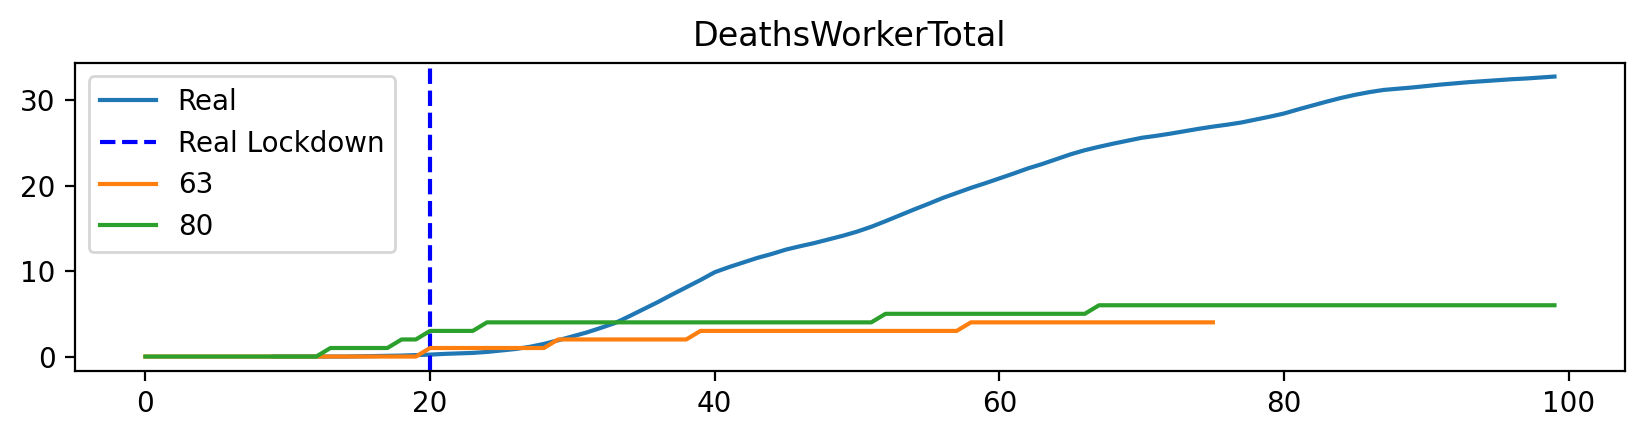

In [77]:
plot_compare_real_sims(turin_data, sims_data, 'DeathsWorkerTotal', simulations_to_compare, plotting_start_date, plotting_end_date)

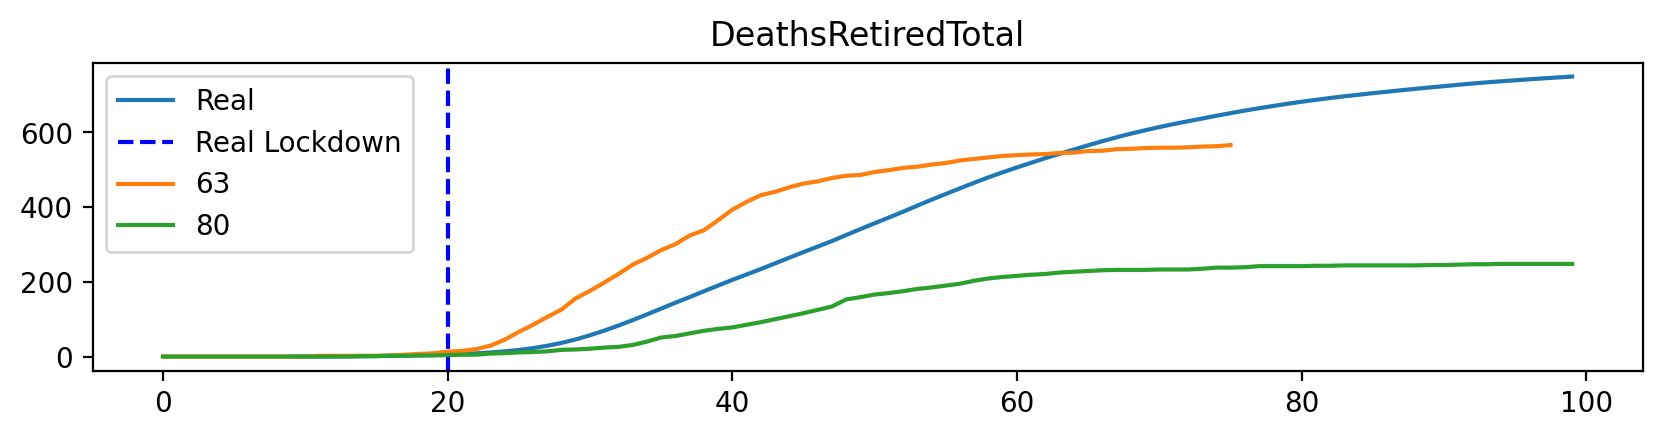

In [78]:
plot_compare_real_sims(turin_data, sims_data, 'DeathsRetiredTotal', simulations_to_compare, plotting_start_date, plotting_end_date)

## Positives

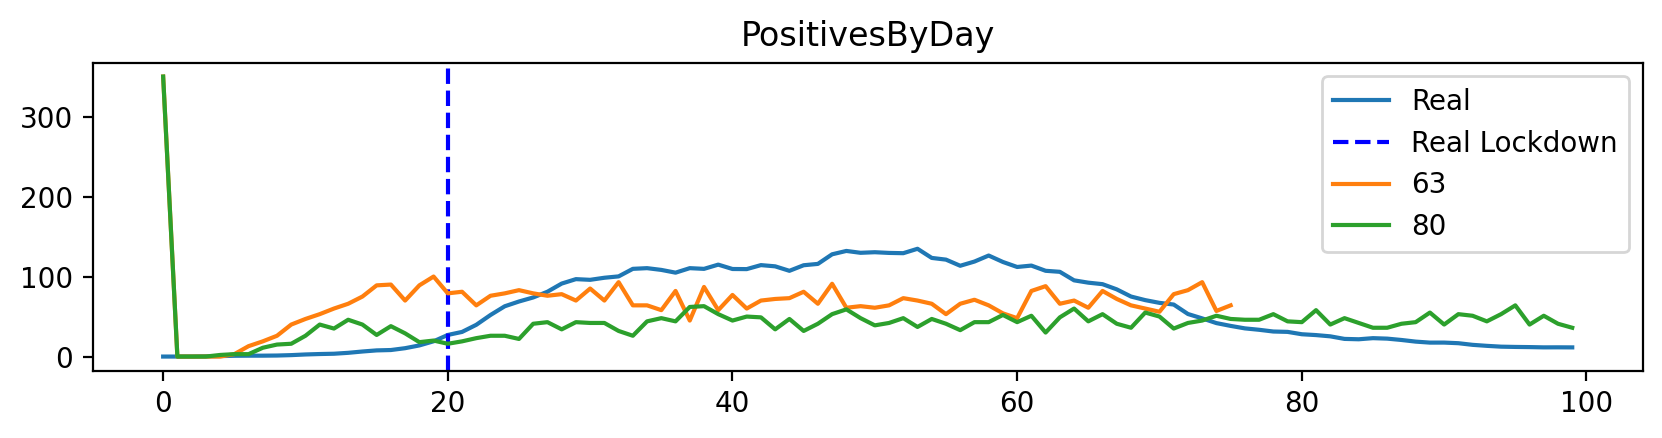

In [79]:
plot_compare_real_sims(turin_data, sims_data, 'PositivesByDay', simulations_to_compare  ,plotting_start_date, plotting_end_date)

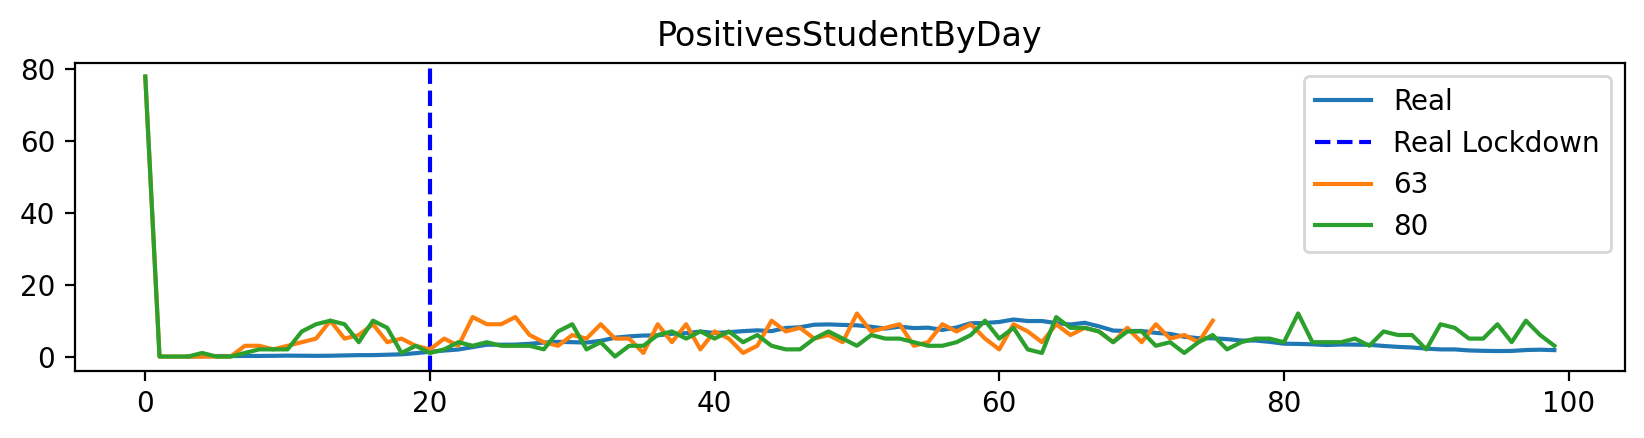

In [80]:
plot_compare_real_sims(turin_data, sims_data, 'PositivesStudentByDay', simulations_to_compare  ,plotting_start_date, plotting_end_date)

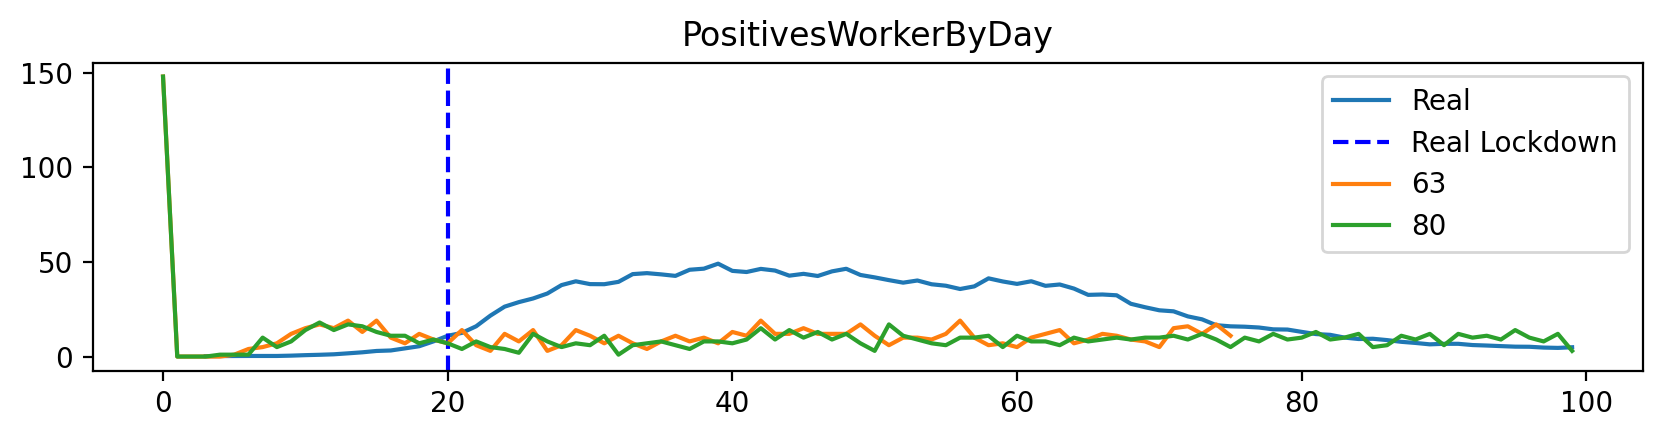

In [81]:
plot_compare_real_sims(turin_data, sims_data, 'PositivesWorkerByDay', simulations_to_compare  ,plotting_start_date, plotting_end_date)

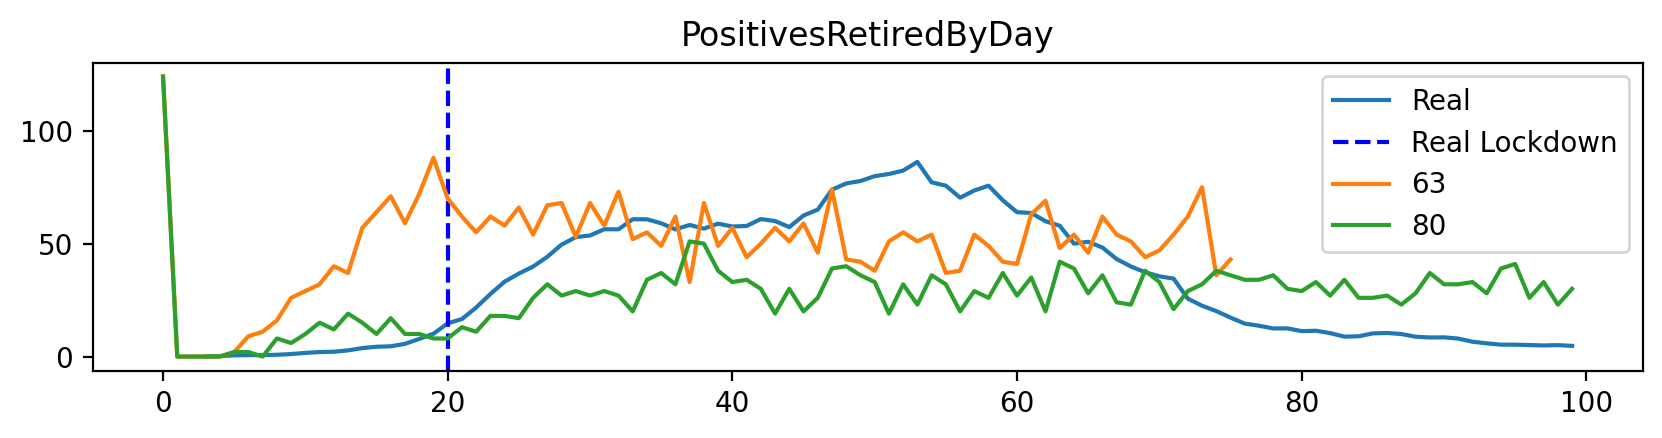

In [82]:
plot_compare_real_sims(turin_data, sims_data, 'PositivesRetiredByDay', simulations_to_compare  ,plotting_start_date, plotting_end_date)

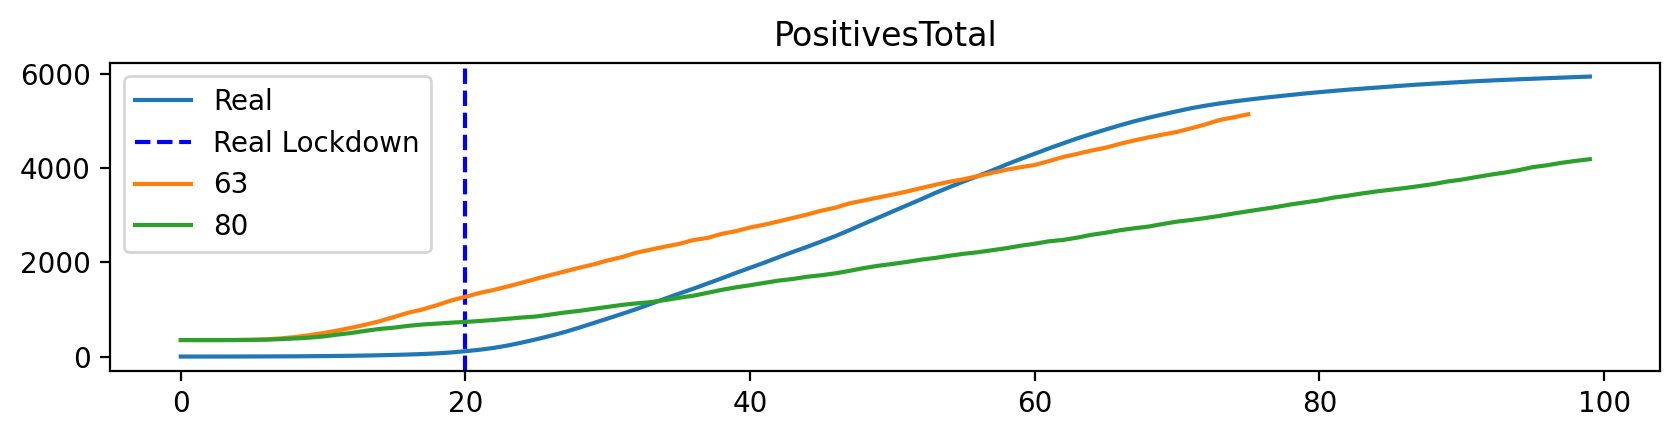

In [83]:
plot_compare_real_sims(turin_data, sims_data, 'PositivesTotal', simulations_to_compare  ,plotting_start_date, plotting_end_date)

## Asymptomatic

The Aymptomatic comparison between real and simulation should be taken with care as we do not have direct asymptomatic data for the real case but only positives and symptomatics and the asymptomatics are calculated as positives - symptomatic

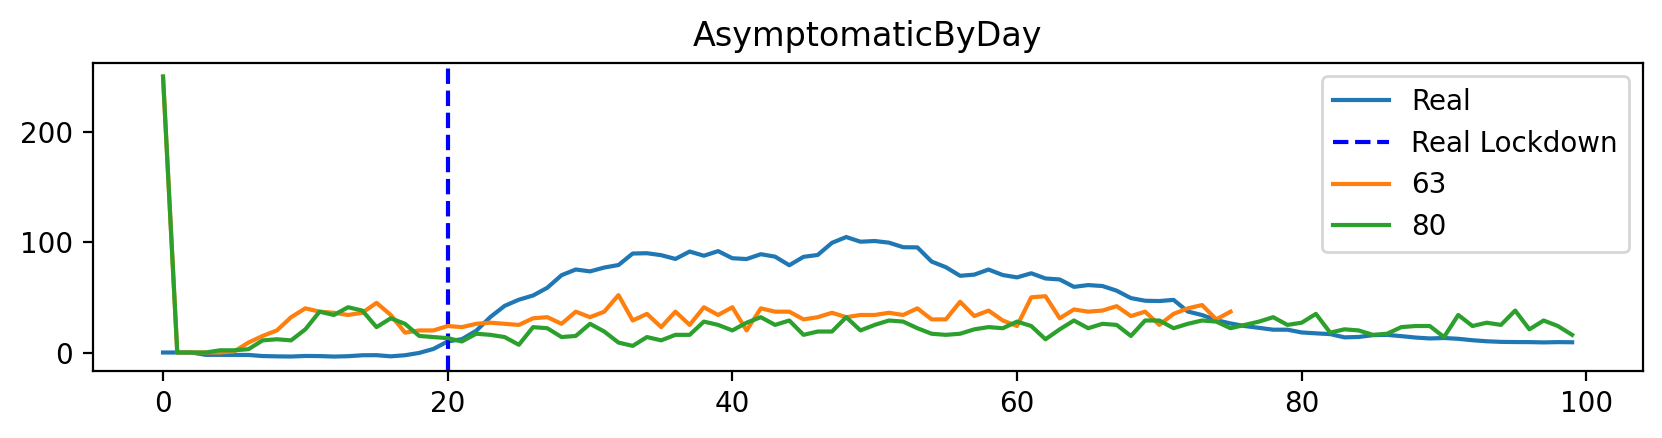

In [84]:
plot_compare_real_sims(turin_data, sims_data, 'AsymptomaticByDay', simulations_to_compare  ,plotting_start_date, plotting_end_date)

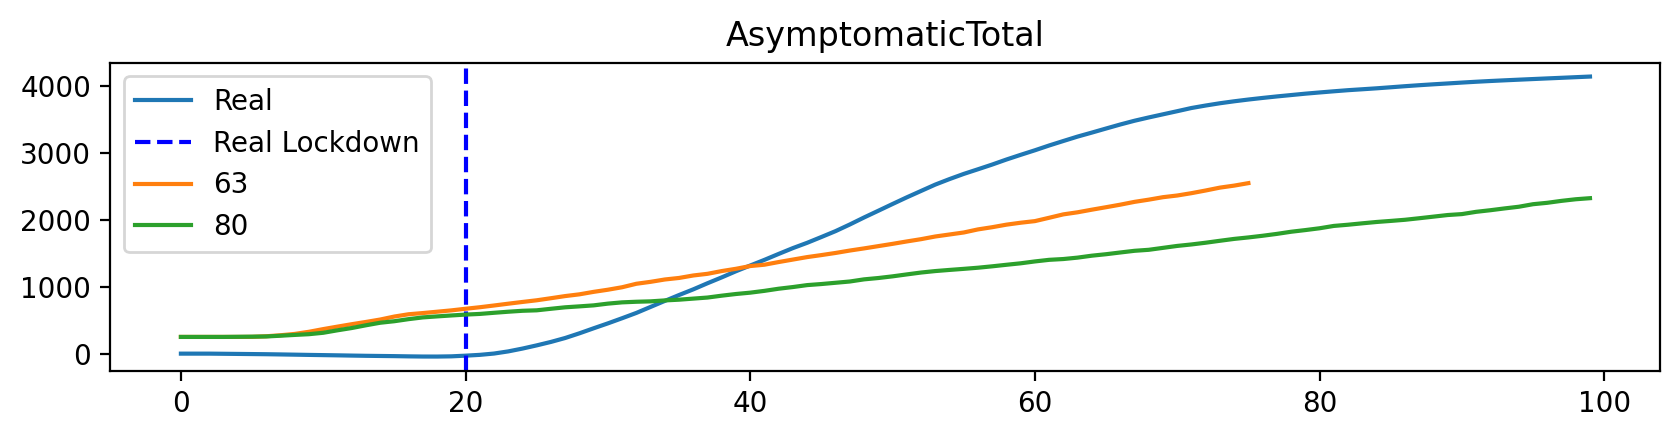

In [85]:
plot_compare_real_sims(turin_data, sims_data, 'AsymptomaticTotal', simulations_to_compare  ,plotting_start_date, plotting_end_date)

## Symptomatics

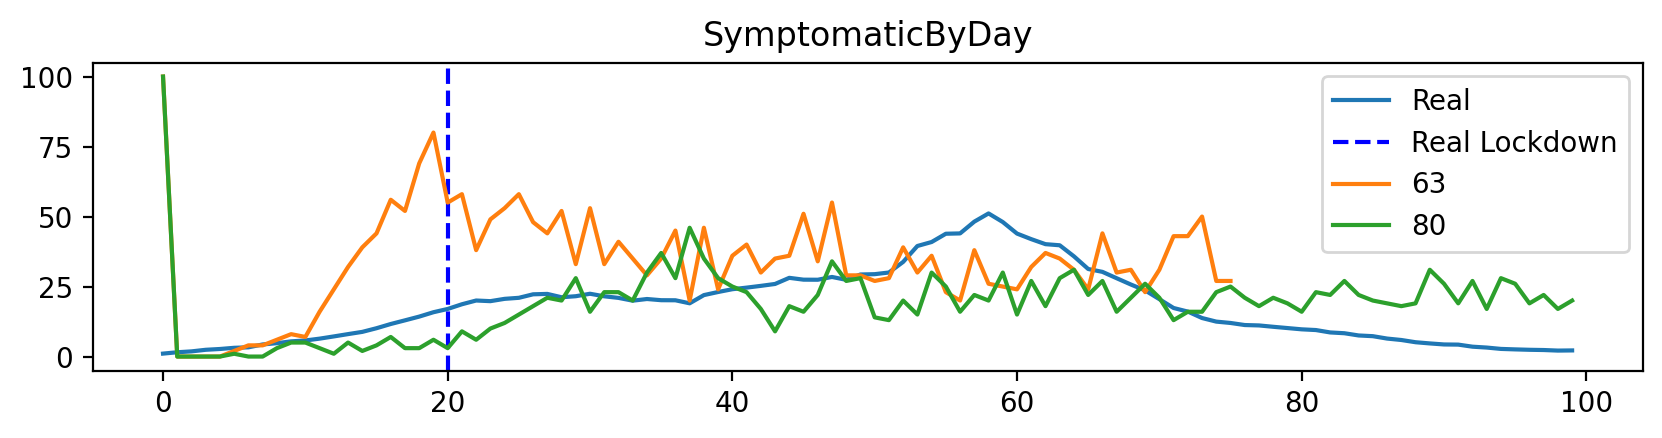

In [86]:
plot_compare_real_sims(turin_data, sims_data, 'SymptomaticByDay', simulations_to_compare  ,plotting_start_date, plotting_end_date)

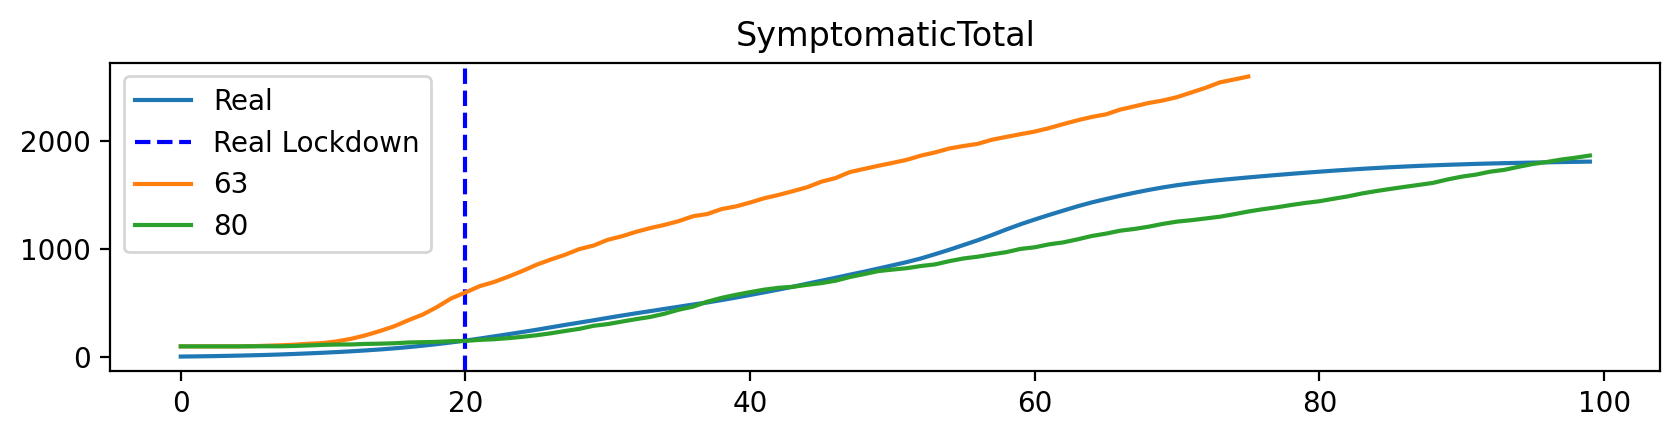

In [87]:
plot_compare_real_sims(turin_data, sims_data, 'SymptomaticTotal', simulations_to_compare  ,plotting_start_date, plotting_end_date)

## Death To Positive

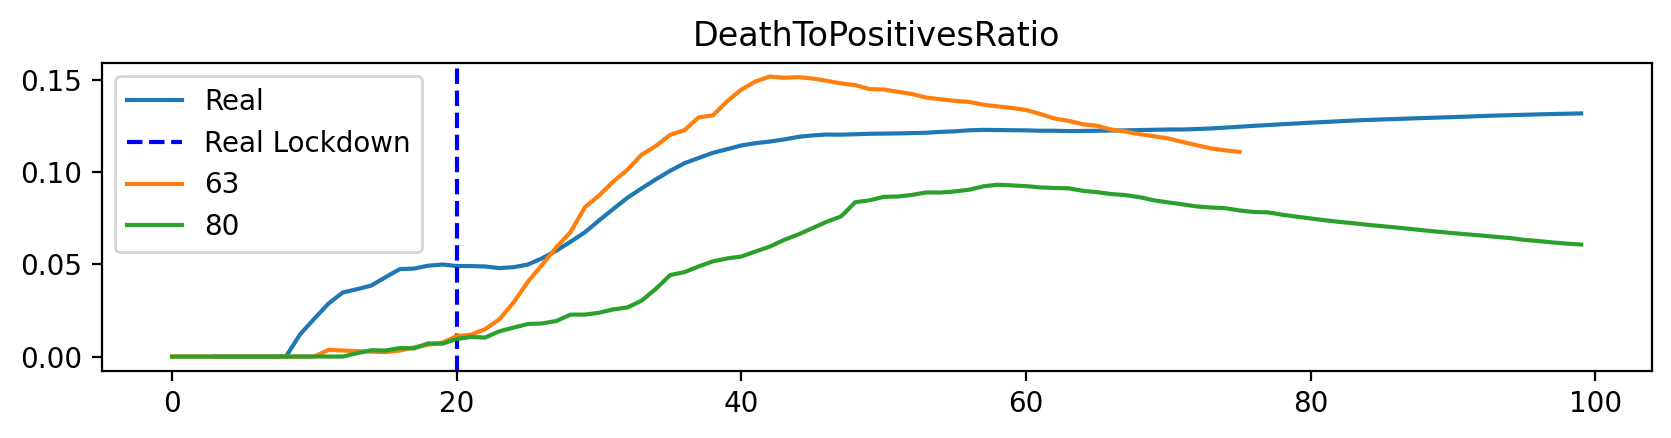

In [88]:
plot_compare_real_sims(turin_data, sims_data, 'DeathToPositivesRatio', simulations_to_compare  ,plotting_start_date, plotting_end_date)

# Simulation Analysis
Here we have an overall analysis of only data coming from the simulations

In [89]:
#simulations_to_compare = [63,64]
#simulations_to_compare = [65,66]
simulations_to_compare = [79,80]

## Compare Simulation Equality

To compare simulation equality we use the root mean square error
[https://vedexcel.com/how-to-calculate-root-mean-squared-error-rmse-in-python/](https://vedexcel.com/how-to-calculate-root-mean-squared-error-rmse-in-python/)

In [90]:
def rms(series_1, series_2, samples_length = -1):
    if samples_length == -1:
        series_1_len = len(series_1)
        series_2_len = len(series_2)
        min_len = min(series_1_len,series_2_len)
    else:
        min_len = samples_length

    series_1_compare = series_1[:min_len].fillna(0).tolist()
    series_2_compare = series_2[:min_len].fillna(0).tolist()
    return sqrt(mean_squared_error(series_1_compare,series_2_compare))

def simulations_rms(sim_1_number, sim_2_number, variable_name, samples_length = -1):
    variable_rms = rms(sims_data[sim_1_number][variable_name], sims_data[sim_2_number][variable_name], samples_length)
    print('Simulations: ' + str(sim_1_number) + ' VS ' + str(sim_2_number) + ' -> RMS on ' + variable_name + ' is: ' + str(variable_rms))

In [91]:
simulations_rms(53,54,'DeathsByDay', 200)
simulations_rms(56,58,'DeathsByDay', 70)
simulations_rms(56,58,'PositivesByDay', 200)
simulations_rms(59,60,'PositivesByDay', 150)
simulations_rms(62,63,'DeathsByDay', 70)

Simulations: 53 VS 54 -> RMS on DeathsByDay is: 0.6633249580710799
Simulations: 56 VS 58 -> RMS on DeathsByDay is: 2.197401062294143
Simulations: 56 VS 58 -> RMS on PositivesByDay is: 10.656453443805777
Simulations: 59 VS 60 -> RMS on PositivesByDay is: 30.532823867656482
Simulations: 62 VS 63 -> RMS on DeathsByDay is: 2.6832815729997477


## Exposure to Infection

In [92]:
def get_infection_location_df(simulation_df):
    columns=['Home','Work','School','RetireHome','FriendsHome','Park','Pub','ExposedOnRoad','Supermarket','Hospital','Gym']
    location_columns=['ExposedAtHome','ExposedAtWork','ExposedAtSchool','ExposedAtRetireHome','ExposedAtFriendsHome','ExposedAtPark','ExposedAtPub','ExposedOnRoad','ExposedAtSupermarket','ExposedAtHospital','ExposedAtGym']
    infection_location_df = simulation_df[location_columns]
    infection_location_df.columns = columns

    infection_location_df['Total'] = simulation_df[location_columns].sum(axis = 1)

    return infection_location_df

def graph_infection_location(simulation_df, days, sim_id):

    infection_location_df = get_infection_location_df(simulation_df)
    infection_location_df = infection_location_df.head(days)

    total_infections = infection_location_df['Total']
    infection_location_df = infection_location_df.drop('Total', axis=1)
    infection_location_prc = infection_location_df.div(total_infections, axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    infection_location_prc.plot(kind="bar", stacked=True, ax=ax1)
    x = np.arange(days)
    n = 10  # Display labels every 2nd row
    x_ticks = x[::n]
    ax1.set_xticks(x_ticks, x_ticks)
    ax1.legend('')

    infection_location_df.plot(ax=ax2)

    fig.suptitle('Simulation: ' + str(sim_id), fontsize=10)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

C:\Users\Utente\AppData\Local\Temp\ipykernel_16772\32153985.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infection_location_df['Total'] = simulation_df[location_columns].sum(axis = 1)


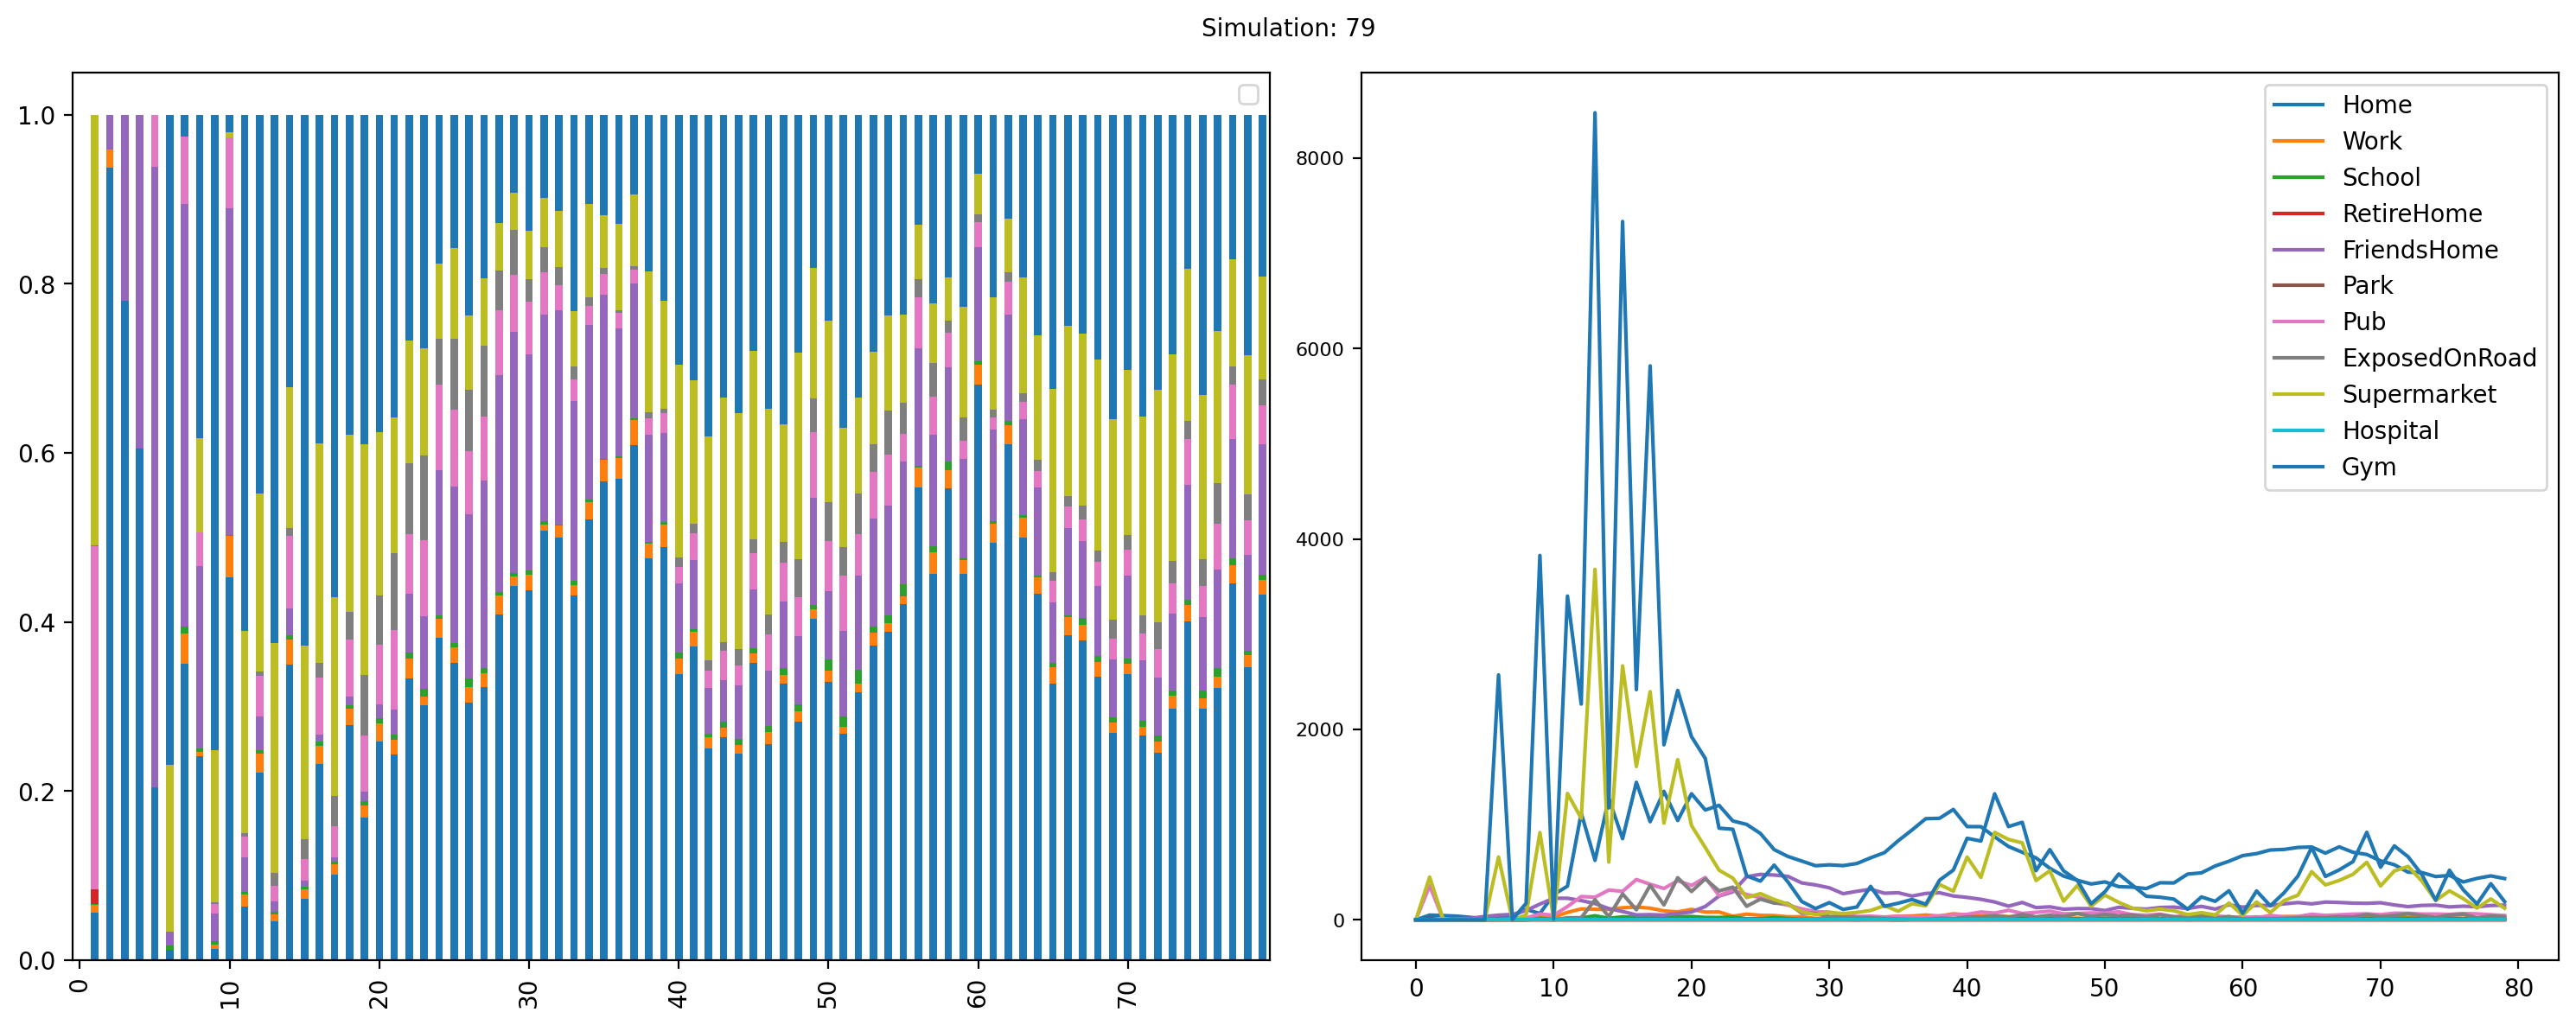

C:\Users\Utente\AppData\Local\Temp\ipykernel_16772\32153985.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infection_location_df['Total'] = simulation_df[location_columns].sum(axis = 1)


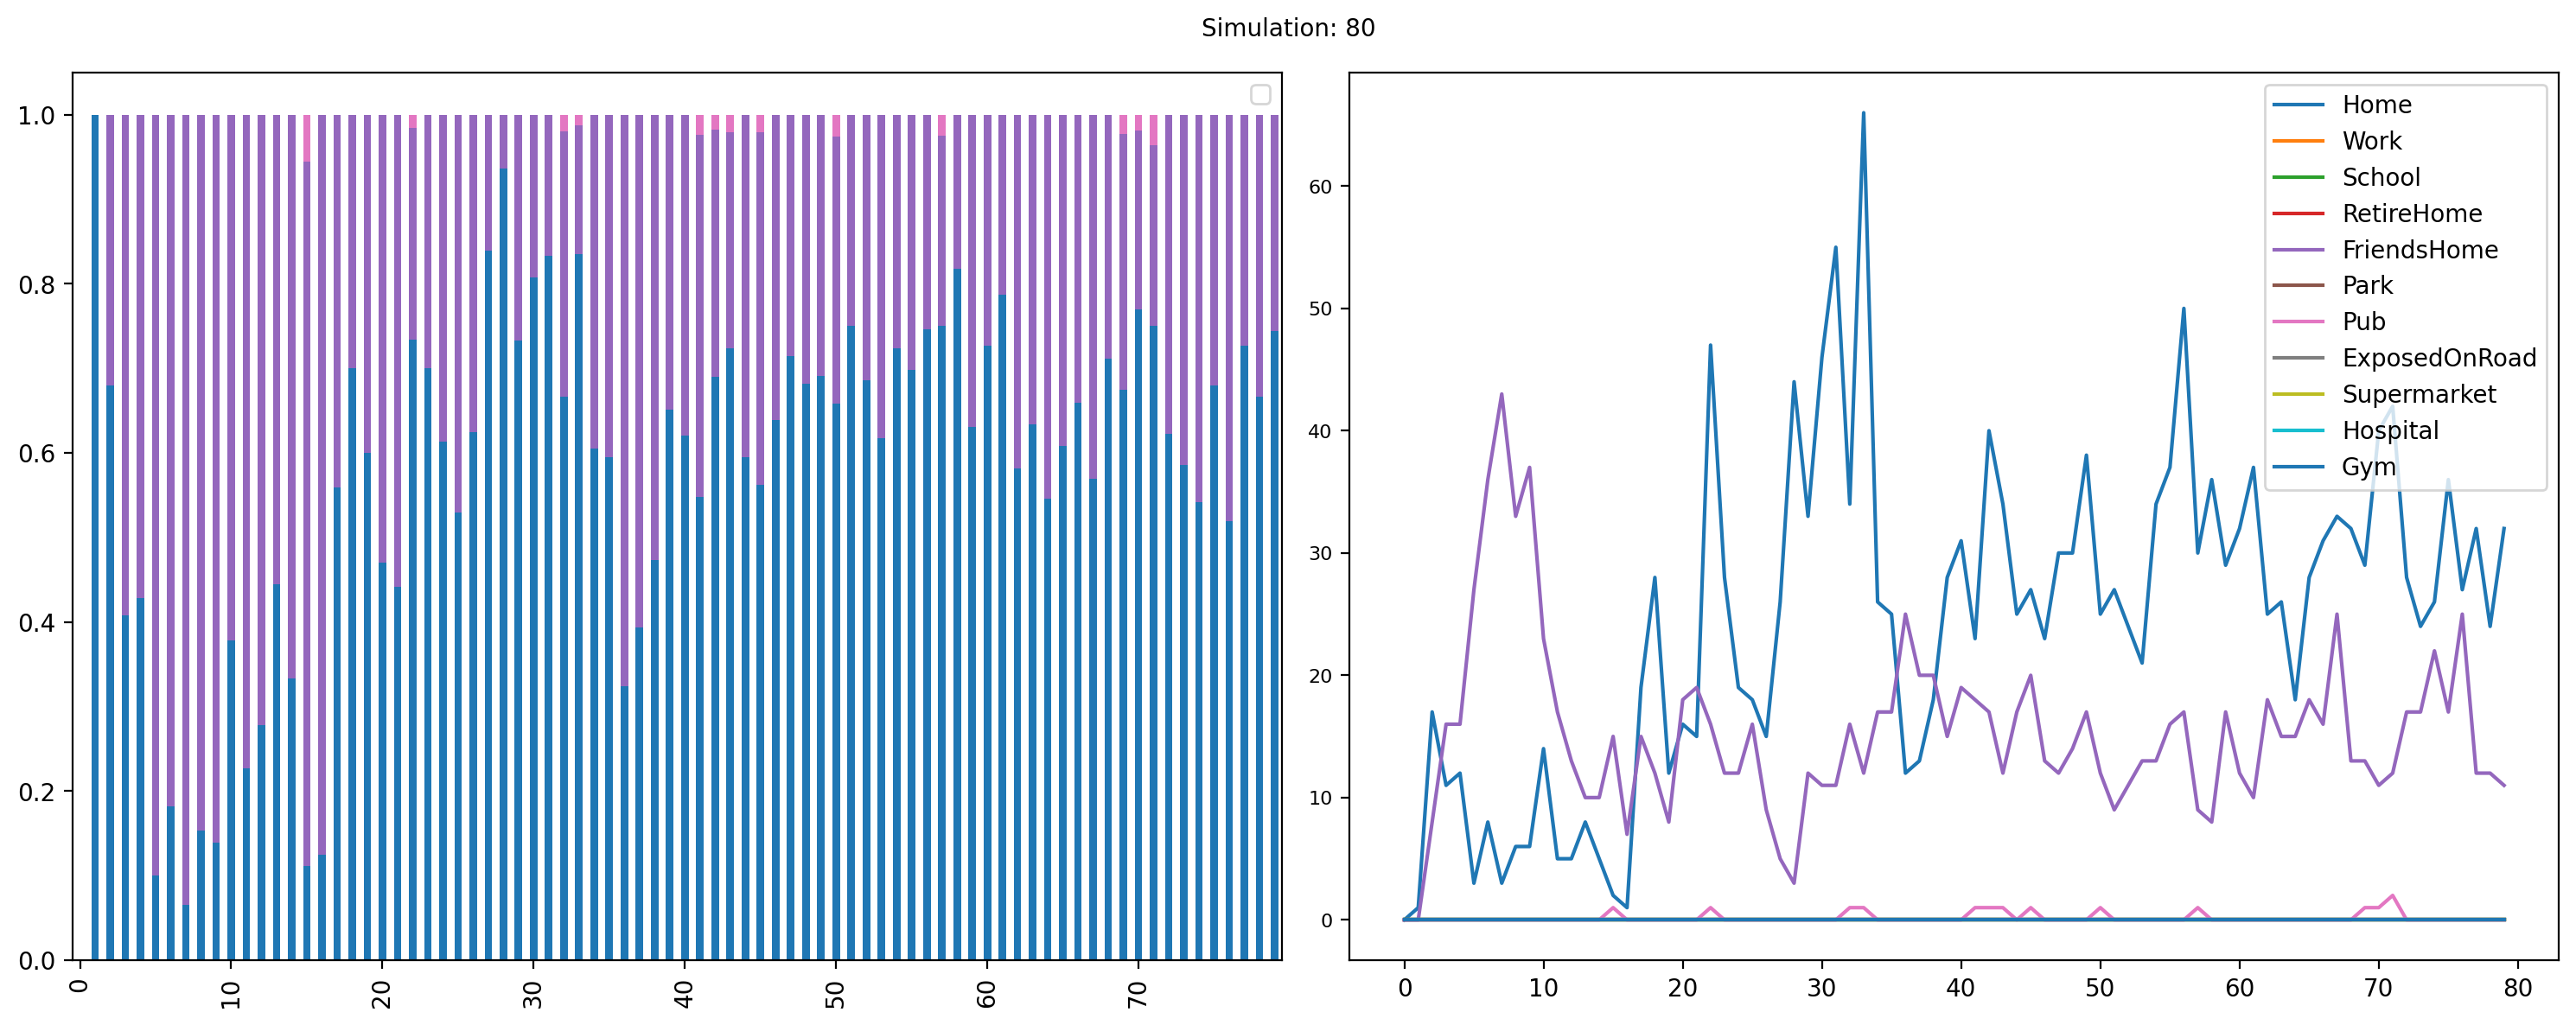

In [93]:
for sim_number in simulations_to_compare:
    graph_infection_location(simulations_logs_df_dictionary[sim_number], 80, sim_number)

In [94]:
table = get_infection_location_df(simulations_logs_df_dictionary[80])
total_infections = table['Total']
table = table.drop('Total', axis=1)
infection_location_prc = table.div(total_infections, axis=0)

# Define the range of rows you want to include in the average calculation
start_row = 1
end_row = 100
selected_rows = infection_location_prc[start_row:end_row]

# Calculate the average for each column within the selected range
column_averages = selected_rows.mean()
print(column_averages)
#infection_location_prc

Home             0.605860
Work             0.000000
School           0.000000
RetireHome       0.000000
FriendsHome      0.390947
Park             0.000000
Pub              0.003193
ExposedOnRoad    0.000000
Supermarket      0.000000
Hospital         0.000000
Gym              0.000000
dtype: float64


C:\Users\Utente\AppData\Local\Temp\ipykernel_16772\32153985.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infection_location_df['Total'] = simulation_df[location_columns].sum(axis = 1)
